In [1]:
import requests
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gmaps
from config import gkey
# 
#
gmaps.configure(api_key = gkey)

In [2]:
# read 911 calls csv
initial_df = pd.read_csv("gs://databucket_for_911/911.csv")
initial_df.head()


,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


In [3]:
# drop useless columns
columns_dropped_1df=initial_df.drop(columns=['desc','twp', 'addr','e'])
columns_dropped_1df.head()

,lat,lng,zip,title,timeStamp
0,40.297876,-75.581294,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52
1,40.258061,-75.264680,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21
2,40.121182,-75.351975,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21
3,40.116153,-75.343513,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36
4,40.251492,-75.603350,NaN,EMS: DIZZINESS,2015-12-10 16:56:52


In [4]:
# Split 'title' into Department and level 2
columns_dropped_1df[['Dept','Type']] = columns_dropped_1df['title'].str.split(': ',expand=True)
# drop the title column
title_split_2df=columns_dropped_1df.drop(columns=['title'])
title_split_2df=title_split_2df.rename(columns={'timeStamp':'TStamp'})
title_split_2df.head()


,lat,lng,zip,TStamp,Dept,Type
0,40.297876,-75.581294,19525.0,2015-12-10 17:10:52,EMS,BACK PAINS/INJURY
1,40.258061,-75.264680,19446.0,2015-12-10 17:29:21,EMS,DIABETIC EMERGENCY
2,40.121182,-75.351975,19401.0,2015-12-10 14:39:21,Fire,GAS-ODOR/LEAK
3,40.116153,-75.343513,19401.0,2015-12-10 16:47:36,EMS,CARDIAC EMERGENCY
4,40.251492,-75.603350,NaN,2015-12-10 16:56:52,EMS,DIZZINESS


In [5]:

# Split timestamp into date and time
title_split_2df[['Date','Time']] = title_split_2df['TStamp'].str.split(' ',expand=True)

# grab the first two characters of the "Time" to have "hour of the day"
title_split_2df["HH"]=title_split_2df["Time"].str[:2]

# use the timestamp to get day of the week, then grab the first 3 characters for a short version
title_split_2df["MMM"]=pd.to_datetime(title_split_2df['TStamp']).dt.month_name().str[:3]
title_split_2df["MM"]=pd.to_datetime(title_split_2df['TStamp']).dt.month

title_split_2df["Date2"]=pd.to_datetime(title_split_2df['TStamp']).dt.strftime('%d/%m/%Y')


# use the date and take the 3 and 4th characters to get Yr
title_split_2df["YY"]=title_split_2df['Date'].str[2:4]


title_split_2df["MMM-YY"] = title_split_2df["MMM"] + "-" +title_split_2df["YY"].astype(str)
title_split_2df["YYMM"] = (title_split_2df["YY"].astype(str) +title_split_2df["MM"].astype(str))


# use the timestamp to get day of the week, then grab the first 3 characters for a short version
title_split_2df["WD"]=pd.to_datetime(title_split_2df['TStamp']).dt.day_name().str[:3]

# use the timestamp to get day of the week by number
title_split_2df["WD#"]=pd.to_datetime(title_split_2df['TStamp']).dt.dayofweek

# Reorder Columns
date_time_fix_3df=title_split_2df[["Dept","Type","YY","MMM","MM","MMM-YY","YYMM","WD","WD#","Date","Date2","HH","Time","TStamp","lat","lng","zip"]]
date_time_fix_3df.head()

,Dept,Type,YY,MMM,MM,MMM-YY,YYMM,WD,WD#,Date,Date2,HH,Time,TStamp,lat,lng,zip
0,EMS,BACK PAINS/INJURY,15,Dec,12,Dec-15,1512,Thu,3,2015-12-10,10/12/2015,17,17:10:52,2015-12-10 17:10:52,40.297876,-75.581294,19525.0
1,EMS,DIABETIC EMERGENCY,15,Dec,12,Dec-15,1512,Thu,3,2015-12-10,10/12/2015,17,17:29:21,2015-12-10 17:29:21,40.258061,-75.264680,19446.0
2,Fire,GAS-ODOR/LEAK,15,Dec,12,Dec-15,1512,Thu,3,2015-12-10,10/12/2015,14,14:39:21,2015-12-10 14:39:21,40.121182,-75.351975,19401.0
3,EMS,CARDIAC EMERGENCY,15,Dec,12,Dec-15,1512,Thu,3,2015-12-10,10/12/2015,16,16:47:36,2015-12-10 16:47:36,40.116153,-75.343513,19401.0
4,EMS,DIZZINESS,15,Dec,12,Dec-15,1512,Thu,3,2015-12-10,10/12/2015,16,16:56:52,2015-12-10 16:56:52,40.251492,-75.603350,NaN


In [6]:
# Checking how many of each
date_time_fix_3df["Dept"].value_counts()

EMS        332692
Traffic    230208
Fire       100622
Name: Dept, dtype: int64

In [7]:
# Checking how many of each type of call
date_time_fix_3df["Type"].value_counts()

VEHICLE ACCIDENT -     148372
DISABLED VEHICLE -      47909
FIRE ALARM              38452
VEHICLE ACCIDENT        36377
FALL VICTIM             34683
                        ...  
ROAD OBSTRUCTION            2
HIT + RUN                   1
PRISONER IN CUSTODY         1
FOOT PATROL                 1
ANIMAL COMPLAINT            1
Name: Type, Length: 95, dtype: int64

In [8]:
# Remove rows where the category level 2 happens less than 10 times
remove_rare_occurances_4df=date_time_fix_3df
remove_rare_occurances_4df=remove_rare_occurances_4df.groupby('Type').filter(lambda x : len(x)>=10)
remove_rare_occurances_4df["Type"].value_counts()

VEHICLE ACCIDENT -        148372
DISABLED VEHICLE -         47909
FIRE ALARM                 38452
VEHICLE ACCIDENT           36377
FALL VICTIM                34683
                           ...  
DROWNING                      32
TRAIN CRASH                   24
STANDBY FOR ANOTHER CO        22
PLANE CRASH                   11
BOMB DEVICE FOUND             10
Name: Type, Length: 78, dtype: int64

# Determine the Date Range for the 911 Call data

In [9]:
# get the min and max date for the sample
min_date=remove_rare_occurances_4df["Date"].min()
min_date_df = remove_rare_occurances_4df[remove_rare_occurances_4df["Date"]==min_date].iloc[0]
min_date_value=f"{min_date_df['MMM']}-{min_date_df['YY']}"

max_date=remove_rare_occurances_4df["Date"].max()
max_date_df = remove_rare_occurances_4df[remove_rare_occurances_4df["Date"]==max_date].iloc[0]
max_date_value=f"{max_date_df['MMM']}-{max_date_df['YY']}"

# Storing these strings for later (to be used in titles of graphs)
%store min_date_value
%store max_date_value

Stored 'min_date_value' (str)
Stored 'max_date_value' (str)


In [10]:
from math import radians, cos, sin, asin, sqrt
from My_Functions import haversine


In [11]:
# Add Distance
from math import radians, cos, sin, asin, sqrt
from My_Functions import haversine
# Read in the philly coorindates variables from another Jupyter Notebook
%store -r Lon_Philly
%store -r Lat_Philly

# new dataframe
distance_to_philly_5df=remove_rare_occurances_4df
distance_to_philly_5df['km from Philly'] = distance_to_philly_5df.apply(lambda row: haversine(
                                            Lon_Philly, 
                                            Lat_Philly, 
                                            row['lng'], 
                                            row['lat']), axis=1)
distance_to_philly_5df.to_csv('distance_from_philly.csv',index=False)
distance_to_philly_5df.head()

,Dept,Type,YY,MMM,MM,MMM-YY,YYMM,WD,WD#,Date,Date2,HH,Time,TStamp,lat,lng,zip,km from Philly
0,EMS,BACK PAINS/INJURY,15,Dec,12,Dec-15,1512,Thu,3,2015-12-10,10/12/2015,17,17:10:52,2015-12-10 17:10:52,40.297876,-75.581294,19525.0,52.2
1,EMS,DIABETIC EMERGENCY,15,Dec,12,Dec-15,1512,Thu,3,2015-12-10,10/12/2015,17,17:29:21,2015-12-10 17:29:21,40.258061,-75.264680,19446.0,35.0
2,Fire,GAS-ODOR/LEAK,15,Dec,12,Dec-15,1512,Thu,3,2015-12-10,10/12/2015,14,14:39:21,2015-12-10 14:39:21,40.121182,-75.351975,19401.0,24.6
3,EMS,CARDIAC EMERGENCY,15,Dec,12,Dec-15,1512,Thu,3,2015-12-10,10/12/2015,16,16:47:36,2015-12-10 16:47:36,40.116153,-75.343513,19401.0,23.7
4,EMS,DIZZINESS,15,Dec,12,Dec-15,1512,Thu,3,2015-12-10,10/12/2015,16,16:56:52,2015-12-10 16:56:52,40.251492,-75.603350,NaN,49.9


# Retrieve fully cleaned data

In [12]:
# read Clean 911 calls csv
Clean_911_df = pd.read_csv("Clean_911.csv")
Clean_911_df.head()

,Dept,Type,YY,MMM,MM,MMM-YY,YYMM,WD,WD#,Date,Date2,HH,Time,TStamp,lat,lng,zip,km from Philly
0,EMS,BACK PAINS/INJURY,15,Dec,12,Dec-15,1512,Thu,3,2015-12-10,10/12/2015,17,17:10:52,2015-12-10 17:10:52,40.297876,-75.581294,19525.0,52.2
1,EMS,DIABETIC EMERGENCY,15,Dec,12,Dec-15,1512,Thu,3,2015-12-10,10/12/2015,17,17:29:21,2015-12-10 17:29:21,40.258061,-75.264680,19446.0,35.0
2,Fire,GAS-ODOR/LEAK,15,Dec,12,Dec-15,1512,Thu,3,2015-12-10,10/12/2015,14,14:39:21,2015-12-10 14:39:21,40.121182,-75.351975,19401.0,24.6
3,EMS,CARDIAC EMERGENCY,15,Dec,12,Dec-15,1512,Thu,3,2015-12-10,10/12/2015,16,16:47:36,2015-12-10 16:47:36,40.116153,-75.343513,19401.0,23.7
4,EMS,DIZZINESS,15,Dec,12,Dec-15,1512,Thu,3,2015-12-10,10/12/2015,16,16:56:52,2015-12-10 16:56:52,40.251492,-75.603350,NaN,49.9


# plot # of 911 calls by Department in pie chart

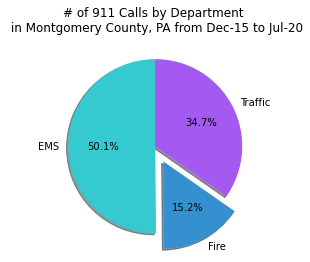

In [13]:
# Generate a pie plot showing the distribution of female versus male mice using pandas

Cat1_df= Clean_911_df.groupby(["Dept"]).count().reset_index()
Cat1_df = Cat1_df[["Dept","lat"]]
Cat1_df = Cat1_df.rename(columns={"lat": "Count"})
Cat1_df["Colours"]=["#35CAD0","#3590D0","#A45AF1"]


Cat1_df.plot(kind="pie", 
               y = "Count", 
               autopct='%1.1f%%',
               legend=False,
               startangle=90,
               shadow=True, 
               labels=Cat1_df["Dept"],
               colors = Cat1_df["Colours"],
               explode = (0.0,0.2,0.0))

%store -r min_date_value
%store -r max_date_value

plt.title(f"# of 911 Calls by Department \n in Montgomery County, PA from {min_date_value} to {max_date_value}")
plt.xlabel("")
plt.ylabel("")
plt.show()

# Investigate types of Traffic 911 calls

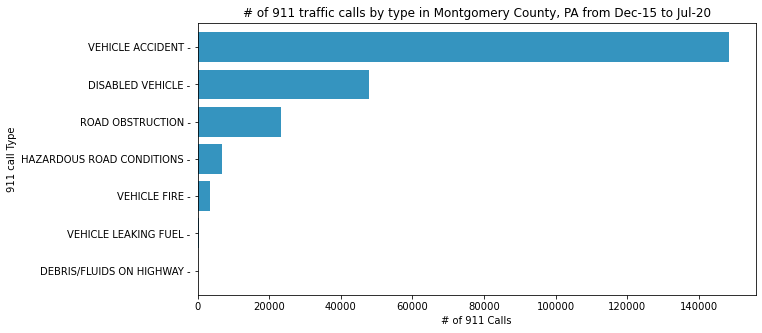

In [14]:
# investigate the different types of traffic 911 calls

# create a new dataframe for traffic and see the different categories for traffic calls
# Copy to new df
Traffic_df=Clean_911_df.copy()

# filter for traffic as cat 1
Traffic_df=Traffic_df.loc[Traffic_df["Dept"]=="Traffic"]

traffic_counts = Traffic_df['Type'].value_counts()
y_axis = np.arange(len(traffic_counts))

#Creating Chart
plt.figure(figsize=(10,5))
traffic_counts.sort_values(ascending=True).plot(kind="barh", width=0.8, color='#3594BF')

#set chart title
%store -r min_date_value
%store -r max_date_value
plt.title(f"# of 911 traffic calls by type in Montgomery County, PA from {min_date_value} to {max_date_value}")

plt.ylabel("911 call Type")
plt.xlabel("# of 911 Calls")
plt.show()

In [22]:
vehicle_accidents_by_day_df


,WD#,Dept,Type,YY,MMM,MM,MMM-YY,YYMM,WD,Date,Date2,HH,Time,TStamp,lat,lng,zip,km from Philly
0,0,21447,21447,21447,21447,21447,21447,21447,21447,21447,21447,21447,21447,21447,21447,21447,18143,21447
1,1,23520,23520,23520,23520,23520,23520,23520,23520,23520,23520,23520,23520,23520,23520,23520,19951,23520
2,2,23402,23402,23402,23402,23402,23402,23402,23402,23402,23402,23402,23402,23402,23402,23402,19948,23402
3,3,23276,23276,23276,23276,23276,23276,23276,23276,23276,23276,23276,23276,23276,23276,23276,19691,23276
4,4,24848,24848,24848,24848,24848,24848,24848,24848,24848,24848,24848,24848,24848,24848,24848,21190,24848
5,5,18508,18508,18508,18508,18508,18508,18508,18508,18508,18508,18508,18508,18508,18508,18508,15303,18508
6,6,13371,13371,13371,13371,13371,13371,13371,13371,13371,13371,13371,13371,13371,13371,13371,10888,13371


# Focus on Vehicle accident calls, When do they happen

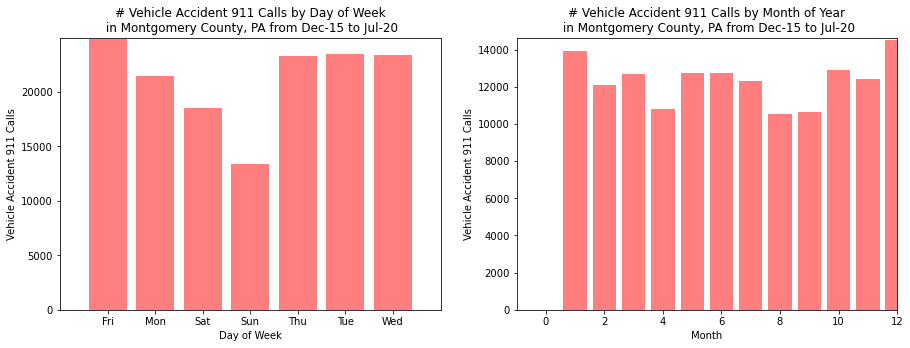

In [26]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
ax1 = axes[0]
ax2 = axes[1]

# retrieve variables for date range for chart titles
%store -r min_date_value
%store -r max_date_value
# dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
# df['Day of Week'] = df['Day of Week'].map(dmap)

# PLOT 1
# Vehicle accident 911 calls by day of the week

# Create a new data frame for vehicle accidents
vehicle_accidents_df=Traffic_df.loc[Traffic_df["Type"]=="VEHICLE ACCIDENT -"]
vehicle_accidents_by_day_df=vehicle_accidents_df.groupby(["WD"]).count().reset_index()

# ax1.bar(vehicle_accidents_by_day_df["WD#"], vehicle_accidents_by_day_df["MM"], color='r', alpha=0.5)
ax1.bar(vehicle_accidents_by_day_df["WD"], vehicle_accidents_by_day_df["MM"], color='r', alpha=0.5)

#ax1.set_xticks(vehicle_accidents_by_day_df["WeekDay#"], vehicle_accidents_by_day_df["WeekDay#"], rotation="vertical")

# Set x and y limits
ax1.set_xlim(-1, len(vehicle_accidents_by_day_df["WD#"]))
ax1.set_ylim(0, max(vehicle_accidents_by_day_df["MM"])+100)

# Set a Title and labels
ax1.set_title(f"# Vehicle Accident 911 Calls by Day of Week\n in Montgomery County, PA from {min_date_value} to {max_date_value}")
ax1.set_xlabel("Day of Week")
ax1.set_ylabel("Vehicle Accident 911 Calls")


# PLOT 2
# Vehicle accident 911 calls by Month of the year

# Create a new data frame for vehicle accidents
vehicle_accidents_df=Traffic_df.loc[Traffic_df["Type"]=="VEHICLE ACCIDENT -"]
vehicle_accidents_by_month_df=vehicle_accidents_df.groupby(["MM"]).count().reset_index()

ax2.bar(vehicle_accidents_by_month_df["MM"], vehicle_accidents_by_month_df["lat"], color='r', alpha=0.5)
#ax2.set_xticks(vehicle_accidents_by_month_df["Mth"], vehicle_accidents_by_month_df["Mth"])#, rotation="vertical")

# Set x and y limits
ax2.set_xlim(-1, len(vehicle_accidents_by_month_df["MM"]))
ax2.set_ylim(0, max(vehicle_accidents_by_month_df["lat"])+100)

# Set a Title and labels
ax2.set_title(f"# Vehicle Accident 911 Calls by Month of Year\n in Montgomery County, PA from {min_date_value} to {max_date_value}")
ax2.set_xlabel("Month")
ax2.set_ylabel("Vehicle Accident 911 Calls")




plt.show()

In [16]:
near_philly_df=vehicle_accidents_df.loc[vehicle_accidents_df["km from Philly"]<7]
near_philly_df

,Dept,Type,YY,MMM,MM,MMM-YY,YYMM,WD,WD#,Date,Date2,HH,Time,TStamp,lat,lng,zip,km from Philly
245319,Traffic,VEHICLE ACCIDENT -,17,Sep,9,Sep-17,179,Fri,4,2017-09-08,08/09/2017,15,15:00:54,2017-09-08 15:00:54,39.991188,-75.213125,19131.0,5.9
291659,Traffic,VEHICLE ACCIDENT -,18,Jan,1,Jan-18,181,Wed,2,2018-01-03,03/01/2018,9,09:35:56,2018-01-03 09:35:56,39.946128,-75.164691,19107.0,0.7
300646,Traffic,VEHICLE ACCIDENT -,18,Jan,1,Jan-18,181,Tue,1,2018-01-23,23/01/2018,13,13:25:09,2018-01-23 13:25:09,39.948365,-75.161872,19107.0,0.5
503269,Traffic,VEHICLE ACCIDENT -,19,Jun,6,Jun-19,196,Sat,5,2019-06-01,01/06/2019,14,14:57:29,2019-06-01 14:57:29,39.936322,-75.203957,NaN,3.8
530958,Traffic,VEHICLE ACCIDENT -,19,Aug,8,Aug-19,198,Wed,2,2019-08-07,07/08/2019,7,07:31:12,2019-08-07 07:31:12,39.948380,-75.155329,19107.0,1.0
560380,Traffic,VEHICLE ACCIDENT -,19,Oct,10,Oct-19,1910,Fri,4,2019-10-18,18/10/2019,17,17:59:57,2019-10-18 17:59:57,39.944382,-75.141490,19106.0,2.2
591477,Traffic,VEHICLE ACCIDENT -,20,Jan,1,Jan-20,201,Wed,2,2020-01-01,01/01/2020,19,19:44:00,2020-01-01 19:44:00,39.946128,-75.164691,19107.0,0.7


In [17]:

locations = near_philly_df[["lat", "lng"]]
figure_layout = {
    'width': '400px',
    'height': '400px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure(layout=figure_layout)

markers = gmaps.marker_layer(locations)
# Add the layer to the map
fig.add_layer(markers)
fig.add_layer(gmaps.traffic_layer())

fig
#sample_accidents_df

Figure(layout=FigureLayout(border='1px solid black', height='400px', margin='0 auto 0 auto', padding='1px', wi…